In [2]:
#conda activat TIL

## boostcourse ai224 1.ipynb

- 쇼핑데이터를 활용한 머신러닝 
    - 정형 데이터 소개 및 EDA

### Library Import

In [199]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import dateutil.relativedelta

## Train 데이터 살펴보기

In [200]:
data = pd.read_csv("./boostcourse/input/train.csv", parse_dates=["order_date"])
print(data.shape) # data shape 확인
data.head()

(780502, 9)


,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


In [201]:
# 데이터 형태 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   order_id     780502 non-null  object        
 1   product_id   780502 non-null  object        
 2   description  780502 non-null  object        
 3   quantity     780502 non-null  int64         
 4   order_date   780502 non-null  datetime64[ns]
 5   price        780502 non-null  float64       
 6   customer_id  780502 non-null  int64         
 7   country      780502 non-null  object        
 8   total        780502 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 53.6+ MB


In [202]:
# 수치형, 범주형 데이터 전체에 대한 기본 통계 반환하기
data.describe(include='all')

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
count,780502,780502,780502,780502.000000,780502,780502.000000,780502.000000,780502,780502.000000
unique,43955,4645,5297,NaN,NaN,NaN,NaN,41,NaN
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom,NaN
freq,542,5096,5096,NaN,NaN,NaN,NaN,700317,NaN
mean,NaN,NaN,NaN,12.623307,2010-12-26 01:08:30.093324288,6.140931,15313.393466,NaN,33.715373
min,NaN,NaN,NaN,-74215.000000,2009-12-01 07:45:00,0.000000,12346.000000,NaN,-127352.940000
25%,NaN,NaN,NaN,2.000000,2010-06-29 11:10:00,2.062500,13963.000000,NaN,7.260000
50%,NaN,NaN,NaN,5.000000,2010-11-28 13:40:00,3.217500,15239.000000,NaN,19.470000
75%,NaN,NaN,NaN,12.000000,2011-07-18 11:55:00,6.187500,16788.000000,NaN,32.175000
max,NaN,NaN,NaN,74215.000000,2011-11-30 17:42:00,64300.500000,18287.000000,NaN,127352.940000


## 함수 정의

### 레이블 생성 함수 정의
* 데이터 프레임, 연-월(문자열), 구매액 임계값 -> binary label
    * 고객별로 임계값보다 적거나 같으면 0, 많으면 1

* 예측 확률
    * 이전 월 고객 총 구매액이 300 초과인 경우 = 1
    * 이전 월 고객 총 구매액이 300 이하인 경우 = 총 구매액 / 300 

In [228]:
def generate_label(df_raw, year_month, total_thres = 300):
    '''
    param
        - 데이터프레임
        - 연월 (문자열)
        - 총 구매액 임계값
    returns
        - 레이블
    '''
    df = df_raw.copy()
    
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    custom_df = df.pivot_table(values='total', index=['customer_id', 'year_month'], aggfunc='sum').reset_index()
    customer_ids = custom_df['customer_id'].unique()

    result_df = custom_df[custom_df['year_month'] == year_month].pivot_table(values='total', index='customer_id', aggfunc='sum').reset_index()
        
    if len(result_df) == 0:
        without_purchase_customers = customer_ids
    else:
        without_purchase_customers = [x for x in customer_ids if x not in result_df['customer_id'].tolist()]
        result_df['label'] = result_df['total'].apply(lambda x: 1 if x > total_thres else 0)

    for i in without_purchase_customers:
        result_df.loc[len(result_df)] = {'customer_id':i, 'total':0, 'label':0}

    return result_df

### 평가지표 출력 함수 정의
* 정확도, 재현율, F1 Score, ROC-AUC score

In [229]:
def print_score(label, pred, prob_thres=0.5):
    '''
    예측된 값이 임계값을 넘으면 1, 이하면 0으로 라벨 생성
    param
        - label(리스트), 예측된 값(리스트), 임계값 
    '''
    print('Precision: {:.5f}'.format(precision_score(label, pred>prob_thres)))
    print('Recall: {:.5f}'.format(recall_score(label, pred>prob_thres)))
    print('F1 Score: {:.5f}'.format(f1_score(label, pred>prob_thres)))
    print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))

### 베이스라인 모델 함수 정의
* (머신러닝 모델을 사용하지 않고) 이전 달의 총 구매액을 (예측)구매확률로 반환

In [230]:
def baseline_model(df, year_month, total_thres=300):
    month = generate_label(df, year_month)
    
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_d = d - dateutil.relativedelta.relativedelta(months=1)
    prev_d = prev_d.strftime('%Y-%m')

    previous_month = generate_label(df, prev_d)

    previous_month = previous_month.rename(columns={'total' : 'previous_total'})
    month = month.merge(previous_month[['customer_id', 'previous_total']], on = 'customer_id', how = 'left')

    month['probability'] = month['previous_total'] / total_thres
    month.loc[month['probability'] > 1, 'probability'] = 1
    month.loc[month['probability'] < 0, 'probability'] = 0

    return month

---

## 모델 사용하기

- 2011년 11월 데이터 생성 (Vaild)
    - 해당 데이터 분포 시각화
    - 해당 데이터 베이스라인 모델 결과 반환
    - 해당 데이터 모델 결과 시각화
- 2011년 12월 데이터 생성 (Test)
    - 해당 데이터 모델 결과 시각화

> 11월 시각화 결과와 12월 시각화 결과를 비교


### 2011년 11월 Label 데이터 생성


In [231]:
label_2011_11 = generate_label(data, "2011-11")['label']

label
0    4594
1    1320
Name: count, dtype: int64

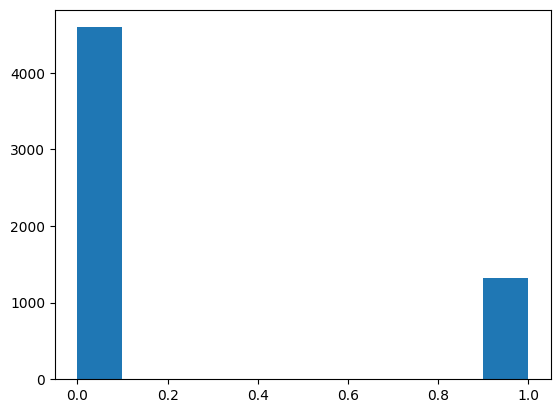

In [232]:
plt.hist(label_2011_11)
label_2011_11.value_counts()

### 2011년 11월 베이스라인 모델 예측

In [233]:
test_preds_2011_11 = baseline_model(data, '2011-11')


In [234]:
print_score(test_preds_2011_11['label'], test_preds_2011_11['probability'])

Precision: 0.39327
Recall: 0.38939
F1 Score: 0.39132
ROC AUC Score: 0.61199


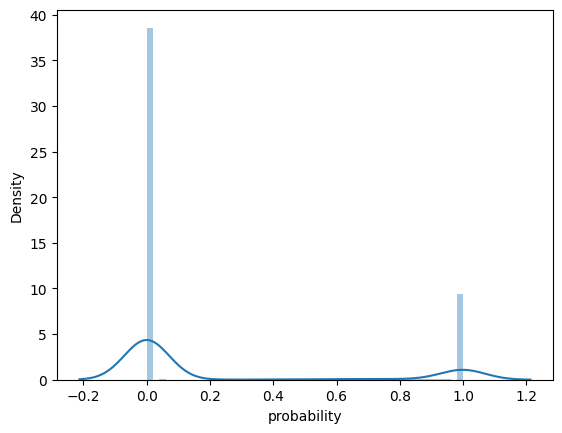

In [235]:
sns.distplot(test_preds_2011_11['probability'])
plt.show()

### 2011년 12월 베이스라인 모델 예측
- 테스트 데이터 제출

In [238]:
test_preds = baseline_model(data, '2011-12')['probability']

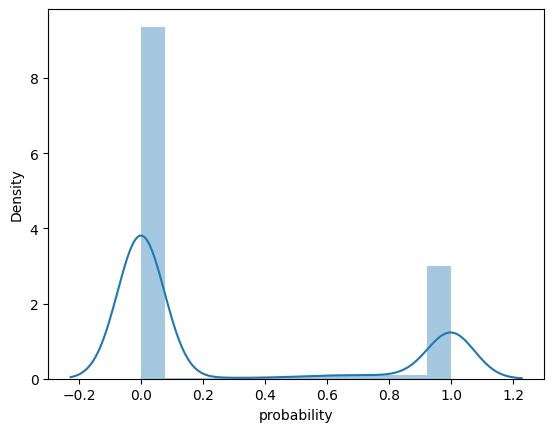

In [239]:
sns.distplot(test_preds)
plt.show()